In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot(*data):
    fig, ax = plt.subplots()
    ax.plot(*data)
    ax.grid()

In [3]:
def dac(period):
    sinus = np.sin(np.linspace(0, 2 * np.pi, period, endpoint=False))
    sinus = np.concat([sinus] * 100)
    return sinus

In [4]:
channels = 2
window = 6000

# block_samples = 432
# n_blocks = 16
# pre_blocks = 4

block_samples = 864
n_blocks = 8
pre_blocks = 4


def adc(signal, offset_blocks=0):
    a = offset_blocks * block_samples
    b = (n_blocks + offset_blocks) * block_samples
    return signal[a:b]

In [5]:
sample_size = 2
size = channels * n_blocks * block_samples * sample_size
print(f"{size / 1024} KB")
assert size <= 28 * 1024

assert block_samples % 12 == 0, "DMA and FIFO length require divisibility by 12"
assert np.log2(n_blocks).is_integer(), "efficient ring buffer implementation"

27.0 KB


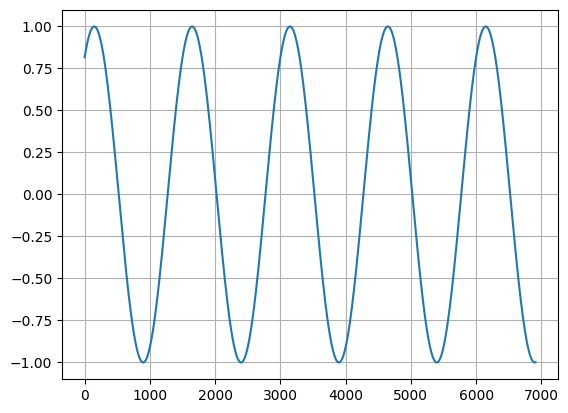

In [6]:
plot(adc(dac(1500), offset_blocks=2))

In [7]:
# every specified sinus period
periods = np.linspace(200, 2000, 901, endpoint=True, dtype=int)

In [8]:
# one extra double sample for a window including the endpoint
end = (n_blocks + pre_blocks) * block_samples - 2
print(f"{end=}")
mid = end - window // 2
print(f"{mid=}")
begin = end - window
print(f"{begin=}")

end=10366
mid=7366
begin=4366


In [9]:
extra = n_blocks * block_samples - 2 - window
print(f"{extra=}")
assert extra > block_samples

extra=910


In [10]:
def offset(period):
    # offset for the window, so that a sinus with period points has a zero crossing at the midpoint
    return begin - (mid % period)

np.max(offsets)=np.int64(4366)
np.min(offsets)=np.int64(2526)


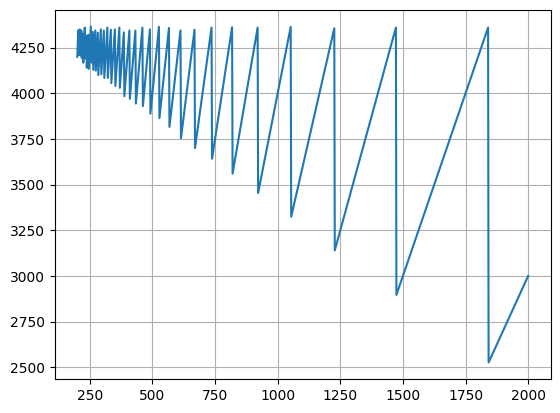

In [11]:
offsets = offset(periods)
plot(periods, offsets)
print(f"{np.max(offsets)=}")
print(f"{np.min(offsets)=}")

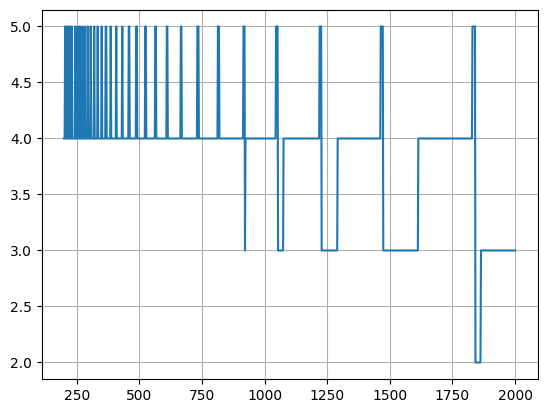

In [12]:
plot(periods, offsets // block_samples)

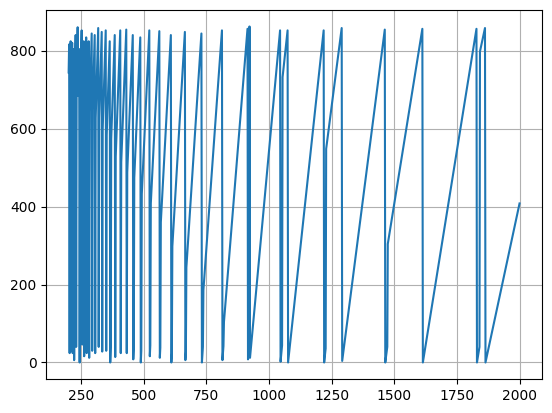

In [13]:
plot(periods, offsets % block_samples)

In [14]:
# the window fits inside the end of memory
assert np.all(offsets + window <= end)
# the window only starts at least 2 blocks into the measurement
assert np.all(2 * block_samples < offsets)

In [15]:
def acquire(period):
    _offset = offset(period)
    _blocks = _offset // block_samples
    _points = _offset % block_samples
    return adc(dac(period), _blocks)[_points : _points + window + 1]

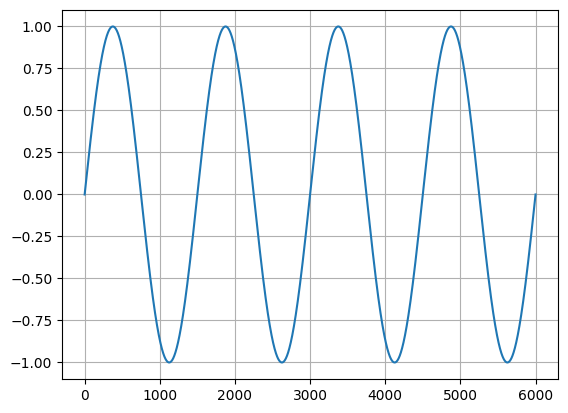

In [16]:
plot(acquire(1500))

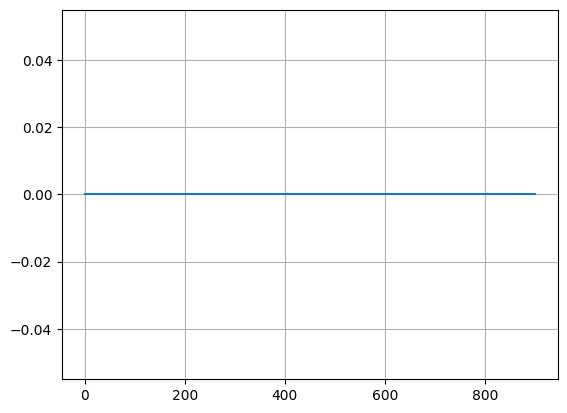

In [17]:
def mid_point(period):
    return acquire(period)[window // 2]


plot(np.vectorize(mid_point)(periods))

In [18]:
for p in periods:
    signal = acquire(p)
    assert signal.shape[0] == window + 1
    # zero crossing at midpoint
    assert signal[window // 2] == 0